In [1]:
# Compute a histogram over the whole of 2020

# For each 6 hour period
#   Load IMERG, IFS ensemble, cGAN ensemble
#   Contribute to the PDF and PDF of the log
#   Save the counts and PDF bins
# Load the PDFs and plot them

# Do a test run first on a small data set, to perfect the bins

import numpy as np
import netCDF4 as nc
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
year = 2020

IMERG_data_dir = "/home/c/cooperf/data/IMERG_6h"
# This is Andrew's quick botch on the data so don't trust it
IFS_data_dir = f"/home/c/cooperf/IFS/IFS-regICPAC-ens-tp"
plot_dir = "/home/c/cooperf/IFS/junk_testing_data/pictures"
save_plots = False

# To be consistent with the Harris et. al paper.
value_range_precip = (0.1, 15)

# Load the constant in time latitude and longitude from a random file
# file_name = IMERG_data_dir + "/3B-HHR.MS.MRG.3IMERG.20210930-S233000-E235959.1410.V06B.HDF5.nc4"
file_name = f"{IMERG_data_dir}/20200101_00.nc4"
nc_file = nc.Dataset(file_name)
latitude = np.array(nc_file["lat"][:])  # Cropping the first point for consistency with the IFS region
longitude = np.array(nc_file["lon"][:])
nc_file.close()

# Should histograms be made (False) or loaded (True)?
load_histograms = True

In [3]:
if (load_histograms == False):
    # Now compare all of the GAN forecasts, IFS forecasts and IMERG data
    # XXX Histograms need to be modified to have bins for each lead time and month
    #     Probably also want to add a mask for the ocean and lake Victoria and perhaps elevation
    
    # Histogram bins
    bins = np.linspace(0,100,10001)
    bins_log = np.linspace(-12.5,3,1001)
    
    # Days for April only
    start_day = (datetime(2020,4,1) - datetime(2020,1,1)).days
    end_day = (datetime(2020,5,1) - datetime(2020,1,1)).days
    num_days = end_day-start_day
    
    IMERG_count_all = np.zeros((num_days,4,len(bins)-1))
    IFS_count_all = np.zeros((num_days,4,len(bins)-1))
    cGAN_count_all = np.zeros((num_days,4,len(bins)-1))
    
    IMERG_log_count_all = np.zeros((num_days,4,len(bins_log)-1))
    IFS_log_count_all = np.zeros((num_days,4,len(bins_log)-1))
    cGAN_log_count_all = np.zeros((num_days,4,len(bins_log)-1))
    
    forecast_times = np.zeros((num_days,4))
    valid_times = np.zeros((num_days,4))
    forecast_times_GAN = np.zeros((num_days,4))
    valid_times_GAN = np.zeros((num_days,4))
    
    for day_num in range(num_days):   # 0 to 365 (366 days in 2020)
        print(day_num)
        for valid_time_num in range(4):  # There are 4 valid times in each GAN forecast
            print(f"{day_num}/{num_days} : {valid_time_num}/4")
    
            # Load example IMERG rainfall
            d = datetime(year,1,2,6*valid_time_num) + timedelta(days=start_day+day_num)
            file_name = f"{IMERG_data_dir}/{year}{d.month:02d}{d.day:02d}_{d.hour:02d}.nc4"
            nc_file = nc.Dataset(file_name)
            IMERG_rain = np.array(nc_file["precipitationCal"][:,:])
            nc_file.close()
            
            # Load example IFS rainfall with a 24 hour lead time
            forecast_start_date = d-timedelta(days=1)  # 24 hour lead time
            file_name = f"{IFS_data_dir}/{year}/tp_{forecast_start_date.month}.nc"
            nc_file = nc.Dataset(file_name)
            forecast_time = np.array(nc_file["time"][forecast_start_date.day-1])
            valid_time = np.array(nc_file["valid_time"][forecast_start_date.day-1,4+valid_time_num])
            tp_IFS_accum = np.array(nc_file["tp"][forecast_start_date.day-1,:,4+valid_time_num:6+valid_time_num,1:,:])*1000/6  # Convert from m/6h to mm/h
            tp_IFS = tp_IFS_accum[:,1,:,:] - tp_IFS_accum[:,0,:,:]
            tp_IFS[tp_IFS<0.0] = 0.0
            nc_file.close()
            
            # Load the cGAN forecast
            file_name = f"data/GAN_forecasts/2020/April/GAN_{start_day+day_num}.nc"
            nc_file = nc.Dataset(file_name)
            forecast_time_GAN = np.array(nc_file["time"][0])
            valid_time_GAN = np.array(nc_file["fcst_valid_time"][0,valid_time_num])
            tp_GAN = np.array(nc_file["precipitation"][0,:,valid_time_num,:,:])
            nc_file.close()
    
            # Compute the rainfall histogram counts
            IMERG_count,_ = np.histogram(IMERG_rain.flatten(), bins)
            IFS_count,_ = np.histogram(tp_IFS.flatten(), bins)
            cGAN_count,_ = np.histogram(tp_GAN.flatten(), bins)
    
            # Compute the log rainfall histogram counts
            IMERG_log_count,_ = np.histogram(np.log(IMERG_rain+1e-5).flatten(), bins_log)
            IFS_log_count,_ = np.histogram(np.log(tp_IFS+1e-5).flatten(), bins_log)
            cGAN_log_count,_ = np.histogram(np.log(tp_GAN+1e-5).flatten(), bins_log)
            
            # Save for later
            IMERG_count_all[day_num,valid_time_num,:] = IMERG_count
            IFS_count_all[day_num,valid_time_num,:] = IFS_count
            cGAN_count_all[day_num,valid_time_num,:] = cGAN_count
    
            IMERG_log_count_all[day_num,valid_time_num,:] = IMERG_log_count
            IFS_log_count_all[day_num,valid_time_num,:] = IFS_log_count
            cGAN_log_count_all[day_num,valid_time_num,:] = cGAN_log_count
            
            forecast_times[day_num,valid_time_num] = forecast_time
            valid_times[day_num,valid_time_num] = valid_time
            forecast_times_GAN[day_num,valid_time_num] = forecast_time_GAN
            valid_times_GAN[day_num,valid_time_num] = valid_time_GAN

    # The bin centers
    x = (bins[:-1] + bins[1:])/2
    x_log = (bins_log[:-1] + bins_log[1:])/2
    
    # How many samples were there in each histogram:
    n_ens = tp_IFS.shape[0]*len(latitude)*len(longitude)
    n_IMERG = len(latitude)*len(longitude)

In [4]:
if (load_histograms == False):
    # Save the data for later processing
    output_data_dir = "data/"
    file_name = "histograms_2020.nc"
    
    # Create a new NetCDF file
    rootgrp = nc.Dataset(f"{output_data_dir}/{file_name}", "w", format="NETCDF4")
    
    # Describe where this data comes from
    rootgrp.description = "IFS and cGAN CRPS vs IMERG rain histograms for 2020."
    
    # Create dimensions
    time_dim = rootgrp.createDimension("time", None)
    valid_time_dim = rootgrp.createDimension("valid_time", 4)
    bin_edges_dim = rootgrp.createDimension("bin_edges", len(bins))
    bin_centers_dim = rootgrp.createDimension("bin_centers", len(bins)-1)
    bin_edges_log_dim = rootgrp.createDimension("bin_edges_log", len(bins_log))
    bin_centers_log_dim = rootgrp.createDimension("bin_centers_log", len(bins_log)-1)
    
    # Create the rainfall bin edges variable
    rainfall_bins_data = rootgrp.createVariable("rainfall_bins", "f4", ("bin_edges"), zlib=False)
    rainfall_bins_data.description = "Rainfall histogram bin edges"
    rainfall_bins_data.units = "mm/h"
    rainfall_bins_data[:] = bins
    
    # Create the rainfall bin centers variable
    rainfall_bin_centers_data = rootgrp.createVariable("rainfall", "f4", ("bin_centers"), zlib=False)
    rainfall_bin_centers_data.description = "Rainfall histogram bin centers"
    rainfall_bin_centers_data.units = "mm/h"
    rainfall_bin_centers_data[:] = x
    
    # Create the log rainfall bin edges variable
    rainfall_log_bins_data = rootgrp.createVariable("rainfall_log_bins", "f4", ("bin_edges_log"), zlib=False)
    rainfall_log_bins_data.description = "Log of rainfall histogram bin edges"
    rainfall_log_bins_data.units = "Log (Rainfall (mm/h) )"
    rainfall_log_bins_data[:] = bins_log
    
    # Create the log rainfall bin edges variable
    rainfall_log_bin_centers_data = rootgrp.createVariable("rainfall_log", "f4", ("bin_centers_log"), zlib=False)
    rainfall_log_bin_centers_data.description = "Log of rainfall histogram bin centers"
    rainfall_log_bin_centers_data.units = "Log (Rainfall (mm/h) )"
    rainfall_log_bin_centers_data[:] = x_log
    
    # Create the time variable
    time_data = rootgrp.createVariable("time", "f4", ("time"), zlib=False)
    time_data.units = "hours since 1900-01-01 00:00:00.0"
    time_data[:] = forecast_times[:,0]     # Write the forecast_times data
        
    # Create the valid_time variable
    valid_time_data = rootgrp.createVariable("valid_time", "f4", ("time","valid_time"), zlib=False)
    valid_time_data.units = "hours since 1900-01-01 00:00:00.0"
    valid_time_data[:] = valid_times     # Write the valid_times data
    
    # Create the IFS_PDF variable
    IMERG_PDF_data = rootgrp.createVariable("IMERG_PDF", "f4", ("time","valid_time","bin_centers"), zlib=True)
    IMERG_PDF_data.description = "IMERG rainfall forecast distribution in the ICPAC region"
    IMERG_PDF_data.units = "Probability density"
    IMERG_PDF_data[:] = IMERG_count_all/n_IMERG     # Write the IMERG_rain_all data
    
    # Create the IFS_PDF variable
    IFS_PDF_data = rootgrp.createVariable("IFS_PDF", "f4", ("time","valid_time","bin_centers"), zlib=True)
    IFS_PDF_data.description = "IFS rainfall forecast distribution in the ICPAC region"
    IFS_PDF_data.units = "Probability density"
    IFS_PDF_data[:] = IFS_count_all/n_ens     # Write the IMERG_rain_all data
    
    # Create the IFS_PDF variable
    cGAN_PDF_data = rootgrp.createVariable("cGAN_PDF", "f4", ("time","valid_time","bin_centers"), zlib=True)
    cGAN_PDF_data.description = "cGAN rainfall forecast distribution in the ICPAC region"
    cGAN_PDF_data.units = "Probability density"
    cGAN_PDF_data[:] = cGAN_count_all/n_ens     # Write the IMERG_rain_all data
    
    # Create the IFS_PDF variable
    IMERG_log_PDF_data = rootgrp.createVariable("IMERG_log_PDF", "f4", ("time","valid_time","bin_centers_log"), zlib=True)
    IMERG_log_PDF_data.description = "IMERG log rainfall forecast distribution in the ICPAC region"
    IMERG_log_PDF_data.units = "Probability density"
    IMERG_log_PDF_data[:] = IMERG_log_count_all/n_IMERG     # Write the IMERG_rain_all data
    
    # Create the IFS_PDF variable
    IFS_log_PDF_data = rootgrp.createVariable("IFS_log_PDF", "f4", ("time","valid_time","bin_centers_log"), zlib=True)
    IFS_log_PDF_data.description = "IFS log rainfall forecast distribution in the ICPAC region"
    IFS_log_PDF_data.units = "Probability density"
    IFS_log_PDF_data[:] = IFS_log_count_all/n_ens     # Write the IMERG_rain_all data
    
    # Create the IFS_PDF variable
    cGAN_log_PDF_data = rootgrp.createVariable("cGAN_log_PDF", "f4", ("time","valid_time","bin_centers_log"), zlib=True)
    cGAN_log_PDF_data.description = "cGAN log rainfall forecast distribution in the ICPAC region"
    cGAN_log_PDF_data.units = "Probability density"
    cGAN_log_PDF_data[:] = cGAN_log_count_all/n_ens     # Write the IMERG_rain_all data
    
    # Close the NetCDF file
    rootgrp.close()

In [5]:
if (load_histograms == False):
    plt.plot(x,np.mean(IMERG_count_all, axis=(0,1))/n_IMERG,label="IMERG")
    plt.plot(x,np.mean(IFS_count_all, axis=(0,1))/n_ens,label="IFS")
    plt.plot(x,np.mean(cGAN_count_all, axis=(0,1))/n_ens,label="cGAN")
    plt.xlim(0,0.5)
    plt.ylim(0,0.06)
    plt.grid()
    plt.title(f"Histograms for 2020")
    plt.xlabel("Rainfall (mm/h)")
    plt.ylabel("Probability density")
    plt.legend()
    plt.show()
    
    plt.plot(x,np.mean(IMERG_count_all, axis=(0,1))/n_IMERG,label="IMERG")
    plt.plot(x,np.mean(IFS_count_all, axis=(0,1))/n_ens,label="IFS")
    plt.plot(x,np.mean(cGAN_count_all, axis=(0,1))/n_ens,label="cGAN")
    plt.xlim(0,10)
    plt.ylim(0,0.0005)
    plt.grid()
    plt.title(f"Histograms for 2020")
    plt.xlabel("Rainfall (mm/h)")
    plt.ylabel("Probability density")
    plt.legend()
    plt.show()
    
    plt.semilogy(x,np.mean(IMERG_count_all, axis=(0,1))/n_IMERG,label="IMERG")
    plt.semilogy(x,np.mean(IFS_count_all, axis=(0,1))/n_ens,label="IFS")
    plt.semilogy(x,np.mean(cGAN_count_all, axis=(0,1))/n_ens,label="cGAN")
    plt.xlim(0,10)
    plt.ylim(1e-7,0.1)
    plt.grid()
    plt.title(f"Histograms for 2020")
    plt.xlabel("Rainfall (mm/h)")
    plt.ylabel("Probability density")
    plt.legend()
    plt.show()

In [6]:
if (load_histograms == False):
    plt.plot(x_log,np.mean(IMERG_log_count_all, axis=(0,1))/n_IMERG,label="IMERG")
    plt.plot(x_log,np.mean(IFS_log_count_all, axis=(0,1))/n_ens,label="IFS")
    plt.plot(x_log,np.mean(cGAN_log_count_all, axis=(0,1))/n_ens,label="cGAN")
    plt.xlim(np.min(x_log), np.max(x_log))
    plt.ylim(0,0.015)
    plt.grid()
    plt.title(f"Histograms for 2020")
    plt.xlabel("Log Rainfall")
    plt.ylabel("Probability density")
    plt.legend()
    plt.show()
    
    plt.semilogy(x_log,np.mean(IMERG_log_count_all, axis=(0,1))/n_IMERG,label="IMERG")
    plt.semilogy(x_log,np.mean(IFS_log_count_all, axis=(0,1))/n_ens,label="IFS")
    plt.semilogy(x_log,np.mean(cGAN_log_count_all, axis=(0,1))/n_ens,label="cGAN")
    #plt.xlim(0,10)
    #plt.ylim(1e-7,0.1)
    plt.grid()
    plt.title(f"Histograms for 2020")
    plt.xlabel("Log Rainfall")
    plt.ylabel("Probability density")
    plt.legend()
    plt.show()

In [7]:
if load_histograms:
    # Load pre-computed histogram data for 2020
    file_name = "data/histograms_2020.nc"
    nc_file = nc.Dataset(file_name)
    rainfall = np.array(nc_file["rainfall"][:])
    rainfall_log = np.array(nc_file["rainfall_log"][:])
    forecast_times = np.array(nc_file["time"][:])
    valid_times = np.array(nc_file["valid_time"][:])
    IMERG_PDF = np.array(nc_file["IMERG_PDF"][:])
    IFS_PDF = np.array(nc_file["IFS_PDF"][:])
    cGAN_PDF = np.array(nc_file["cGAN_PDF"][:])
    IMERG_log_PDF = np.array(nc_file["IMERG_log_PDF"][:])
    IFS_log_PDF = np.array(nc_file["IFS_log_PDF"][:])
    cGAN_log_PDF = np.array(nc_file["cGAN_log_PDF"][:])
    nc_file.close()

In [8]:
print("Is the integral equal to 1?")

dx = rainfall[1] - rainfall[0]

print(np.min(np.sum(IMERG_PDF, axis=2)*dx))
print(np.max(np.sum(IMERG_PDF, axis=2)*dx))

print(np.min(np.sum(IFS_PDF, axis=2)*dx))
print(np.max(np.sum(IFS_PDF, axis=2)*dx))

print(np.min(np.sum(cGAN_PDF, axis=2)*dx))
print(np.max(np.sum(cGAN_PDF, axis=2)*dx))

dx_log = rainfall_log[1] - rainfall_log[0]

print(np.min(np.sum(IMERG_log_PDF, axis=2)*dx_log))
print(np.max(np.sum(IMERG_log_PDF, axis=2)*dx_log))

print(np.min(np.sum(IFS_log_PDF, axis=2)*dx_log))
print(np.max(np.sum(IFS_log_PDF, axis=2)*dx_log))

print(np.min(np.sum(cGAN_log_PDF, axis=2)*dx_log))
print(np.max(np.sum(cGAN_log_PDF, axis=2)*dx_log))

Is the integral equal to 1?
0.9999997
1.0000004
0.9999997
1.0000004
0.9999997
1.0000004
1.0000174
1.0000179
1.0000175
1.000018
1.0000176
1.0000179


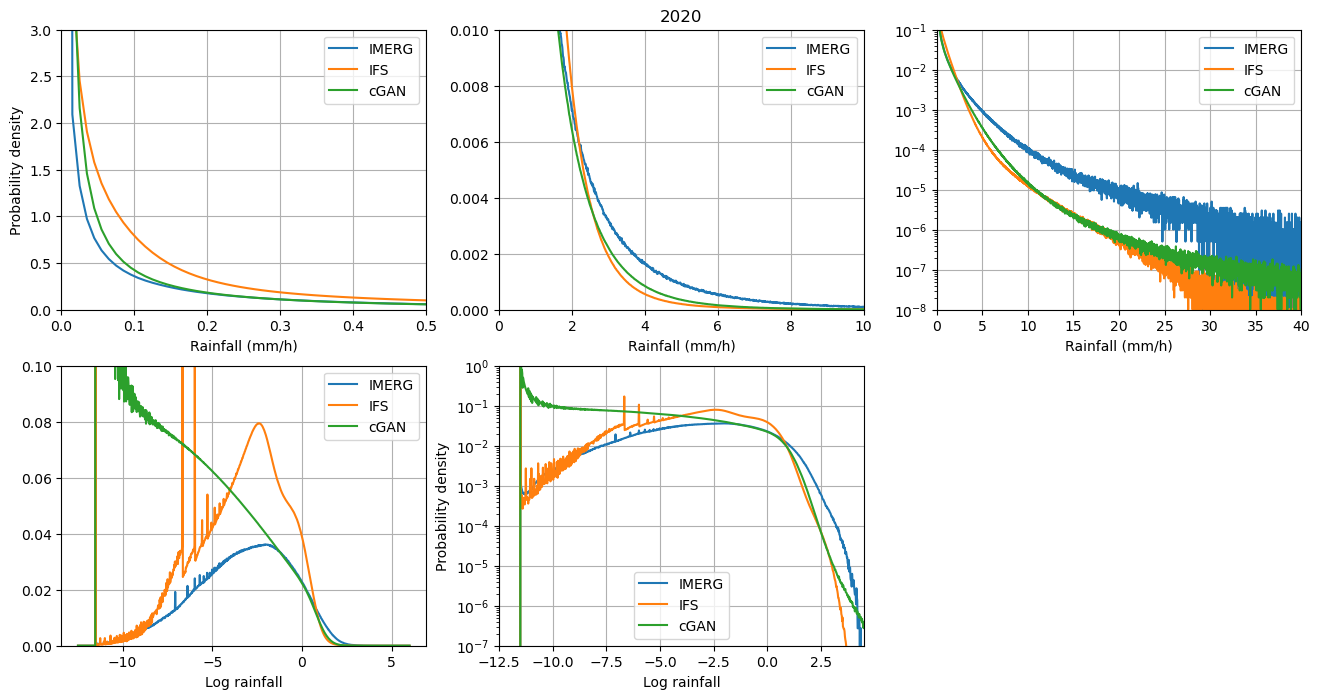

In [9]:
# Define the figure and each axis for the rows and columns
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,8))

# axs is a 2 dimensional array. Flatten it into a 1-D array
axs=axs.flatten()

# Make the plots

ax=axs[0]
ax.plot(rainfall, np.mean(IMERG_PDF, axis=(0,1)), label="IMERG")
ax.plot(rainfall, np.mean(IFS_PDF, axis=(0,1)) ,label="IFS")
ax.plot(rainfall, np.mean(cGAN_PDF, axis=(0,1)), label="cGAN")
ax.set_xlim(0,0.5)
ax.set_ylim(0,3)
ax.grid()
ax.set_xlabel("Rainfall (mm/h)")
ax.set_ylabel("Probability density")
ax.legend()

ax=axs[1]
ax.plot(rainfall, np.mean(IMERG_PDF, axis=(0,1)), label="IMERG")
ax.plot(rainfall, np.mean(IFS_PDF, axis=(0,1)) ,label="IFS")
ax.plot(rainfall, np.mean(cGAN_PDF, axis=(0,1)), label="cGAN")
ax.set_xlim(0,10)
ax.set_ylim(0,0.01)
ax.grid()
ax.set_xlabel("Rainfall (mm/h)")
ax.set_title("2020")
ax.legend()

ax=axs[2]
ax.semilogy(rainfall, np.mean(IMERG_PDF, axis=(0,1)), label="IMERG")
ax.semilogy(rainfall, np.mean(IFS_PDF, axis=(0,1)) , label="IFS")
ax.semilogy(rainfall, np.mean(cGAN_PDF, axis=(0,1)), label="cGAN")
ax.set_xlim(0,40)
ax.set_ylim(1e-8, 1e-1)
ax.grid()
ax.set_xlabel("Rainfall (mm/h)")
ax.legend()

ax=axs[3]
ax.plot(rainfall_log, np.mean(IMERG_log_PDF, axis=(0,1)), label="IMERG")
ax.plot(rainfall_log, np.mean(IFS_log_PDF, axis=(0,1)), label="IFS")
ax.plot(rainfall_log, np.mean(cGAN_log_PDF, axis=(0,1)), label="cGAN")
ax.set_ylim(0,0.1)
ax.grid()
ax.set_xlabel("Log rainfall")
ax.legend()

ax=axs[4]
ax.semilogy(rainfall_log, np.mean(IMERG_log_PDF, axis=(0,1)), label="IMERG")
ax.semilogy(rainfall_log, np.mean(IFS_log_PDF, axis=(0,1)), label="IFS")
ax.semilogy(rainfall_log, np.mean(cGAN_log_PDF, axis=(0,1)), label="cGAN")
ax.set_xlim(-12.5,4.5)
ax.set_ylim(1e-7,1)
ax.grid()
ax.set_xlabel("Log rainfall")
ax.set_ylabel("Probability density")
ax.legend()

ax=axs[5]
ax.axis('off')

# Save the picture
if save_plots:
    plt.savefig(f"{plot_dir}/Rainfall_PDF_2020.png", format="png", bbox_inches='tight')

plt.show()

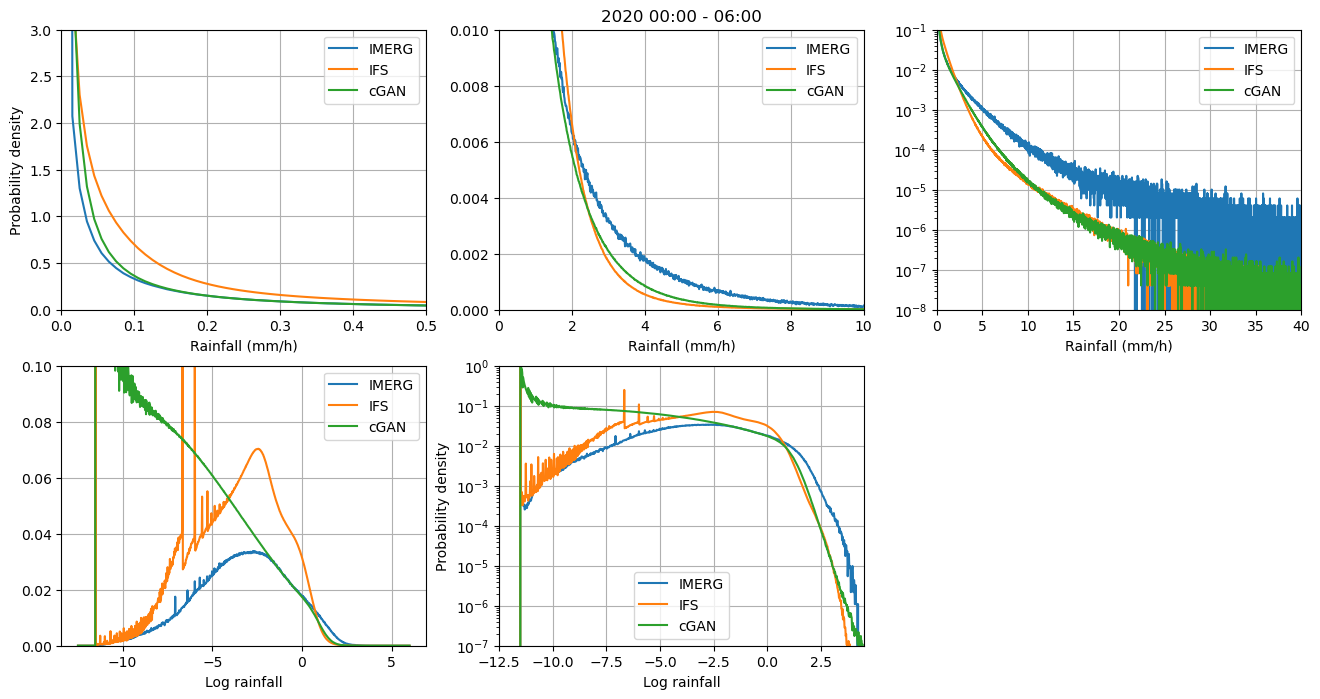

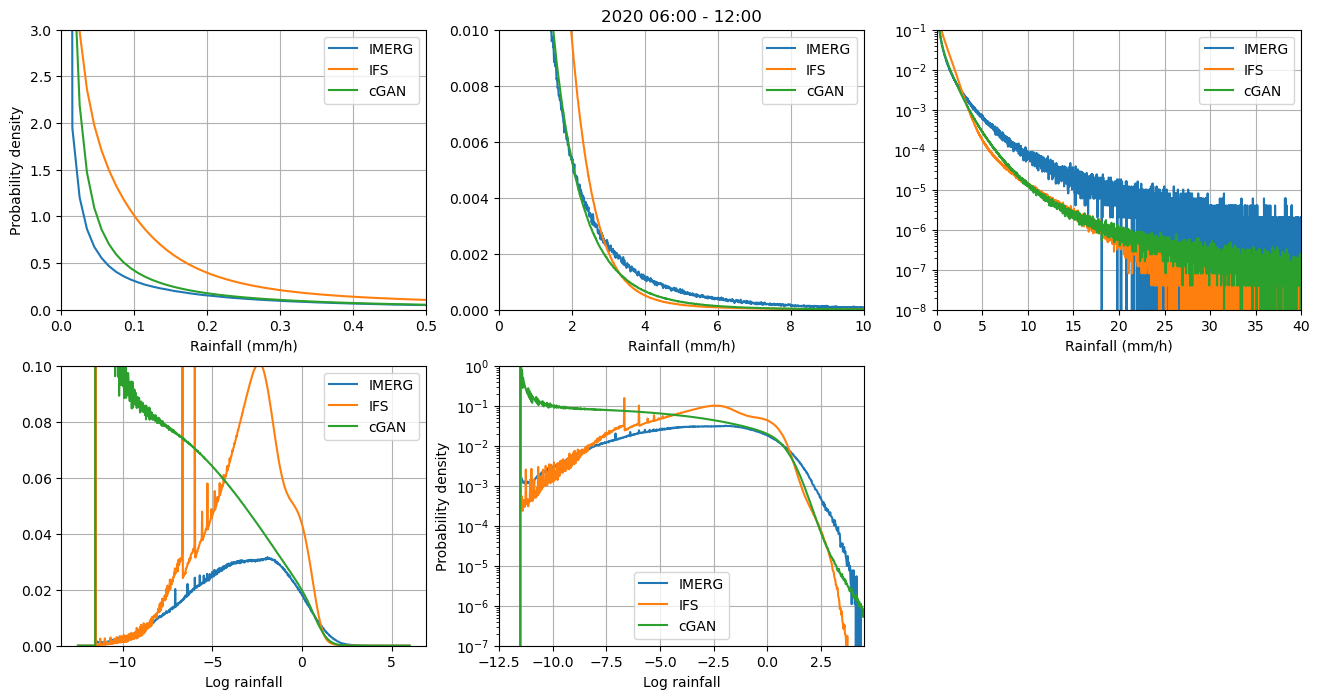

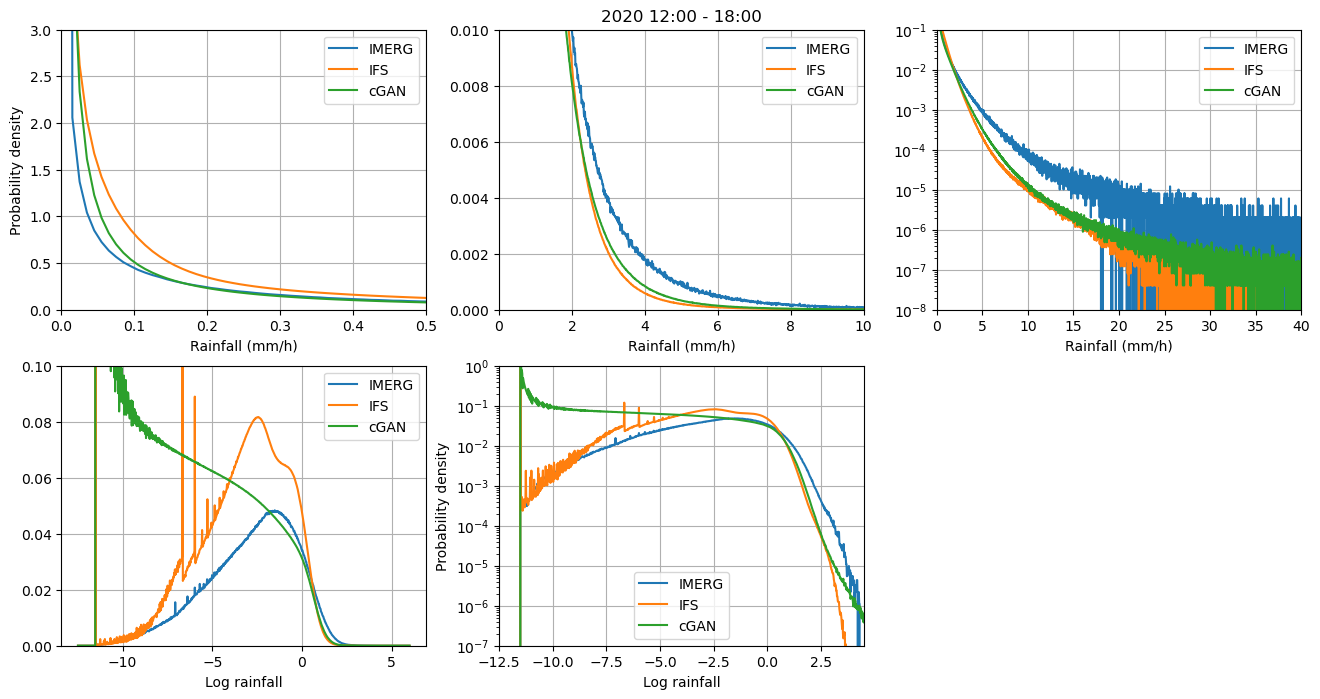

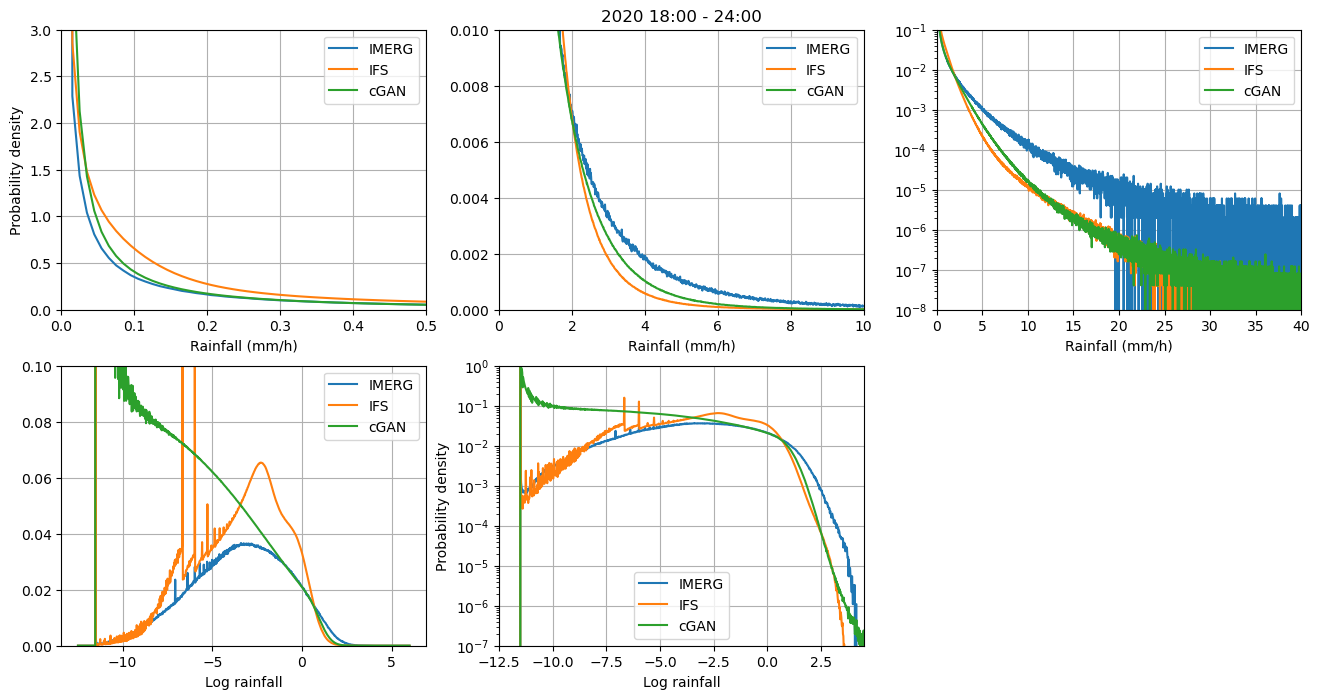

In [10]:
for i in range(4):
    # Define the figure and each axis for the rows and columns
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,8))
    
    # axs is a 2 dimensional array. Flatten it into a 1-D array
    axs=axs.flatten()
    
    # Make the plots
    
    ax=axs[0]
    ax.plot(rainfall, np.mean(IMERG_PDF[:,i,:], axis=0), label="IMERG")
    ax.plot(rainfall, np.mean(IFS_PDF[:,i,:], axis=0) ,label="IFS")
    ax.plot(rainfall, np.mean(cGAN_PDF[:,i,:], axis=0), label="cGAN")
    ax.set_xlim(0,0.5)
    ax.set_ylim(0,3)
    ax.grid()
    ax.set_xlabel("Rainfall (mm/h)")
    ax.set_ylabel("Probability density")
    ax.legend()
    
    ax=axs[1]
    ax.plot(rainfall, np.mean(IMERG_PDF[:,i,:], axis=0), label="IMERG")
    ax.plot(rainfall, np.mean(IFS_PDF[:,i,:], axis=0) ,label="IFS")
    ax.plot(rainfall, np.mean(cGAN_PDF[:,i,:], axis=0), label="cGAN")
    ax.set_xlim(0,10)
    ax.set_ylim(0,0.01)
    ax.grid()
    ax.set_xlabel("Rainfall (mm/h)")
    ax.set_title(f"2020 {i*6:02}:00 - {(i+1)*6:02}:00")
    ax.legend()
    
    ax=axs[2]
    ax.semilogy(rainfall, np.mean(IMERG_PDF[:,i,:], axis=0), label="IMERG")
    ax.semilogy(rainfall, np.mean(IFS_PDF[:,i,:], axis=0) , label="IFS")
    ax.semilogy(rainfall, np.mean(cGAN_PDF[:,i,:], axis=0), label="cGAN")
    ax.set_xlim(0,40)
    ax.set_ylim(1e-8, 1e-1)
    ax.grid()
    ax.set_xlabel("Rainfall (mm/h)")
    ax.legend()
    
    ax=axs[3]
    ax.plot(rainfall_log, np.mean(IMERG_log_PDF[:,i,:], axis=0), label="IMERG")
    ax.plot(rainfall_log, np.mean(IFS_log_PDF[:,i,:], axis=0), label="IFS")
    ax.plot(rainfall_log, np.mean(cGAN_log_PDF[:,i,:], axis=0), label="cGAN")
    ax.set_ylim(0,0.1)
    ax.grid()
    ax.set_xlabel("Log rainfall")
    ax.legend()
    
    ax=axs[4]
    ax.semilogy(rainfall_log, np.mean(IMERG_log_PDF[:,i,:], axis=0), label="IMERG")
    ax.semilogy(rainfall_log, np.mean(IFS_log_PDF[:,i,:], axis=0), label="IFS")
    ax.semilogy(rainfall_log, np.mean(cGAN_log_PDF[:,i,:], axis=0), label="cGAN")
    ax.set_xlim(-12.5,4.5)
    ax.set_ylim(1e-7,1)
    ax.grid()
    ax.set_xlabel("Log rainfall")
    ax.set_ylabel("Probability density")
    ax.legend()
    
    ax=axs[5]
    ax.axis('off')

    # Save the picture
    if save_plots:
        plt.savefig(f"{plot_dir}/Rainfall_PDF_2020_{i*6:02}-{(i+1)*6:02}.png", format="png", bbox_inches='tight')
    
    plt.show()

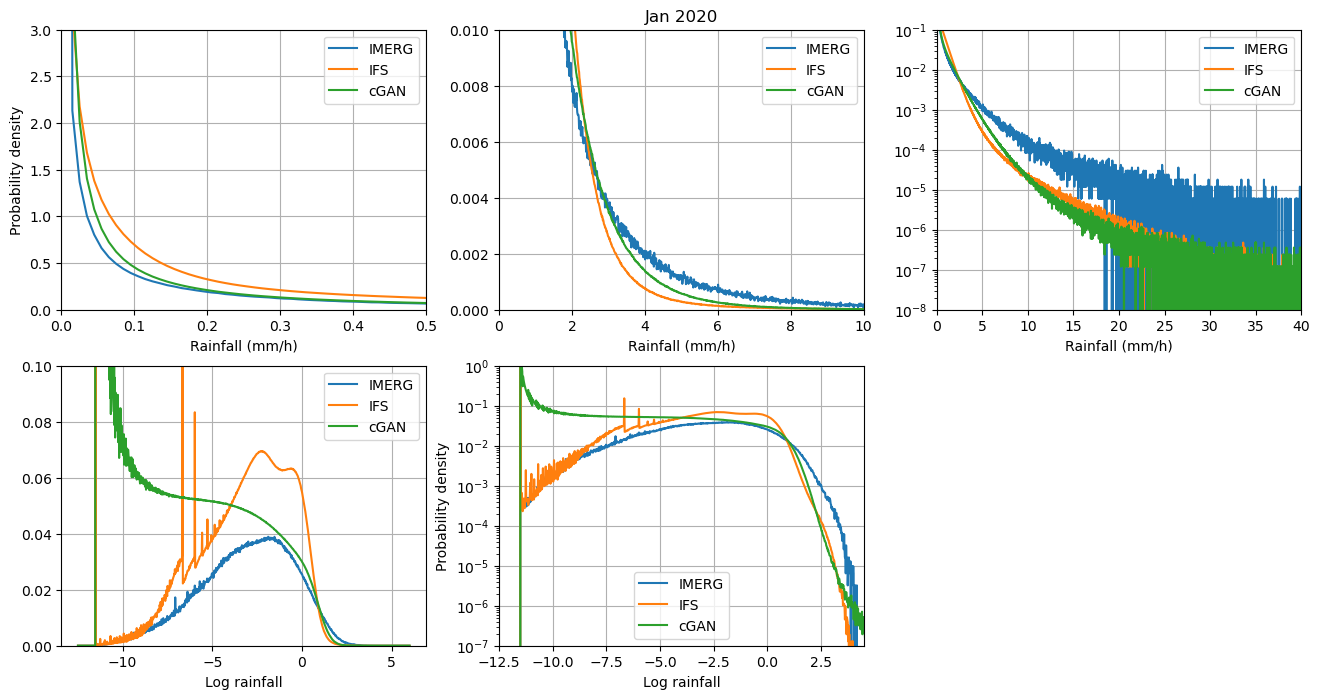

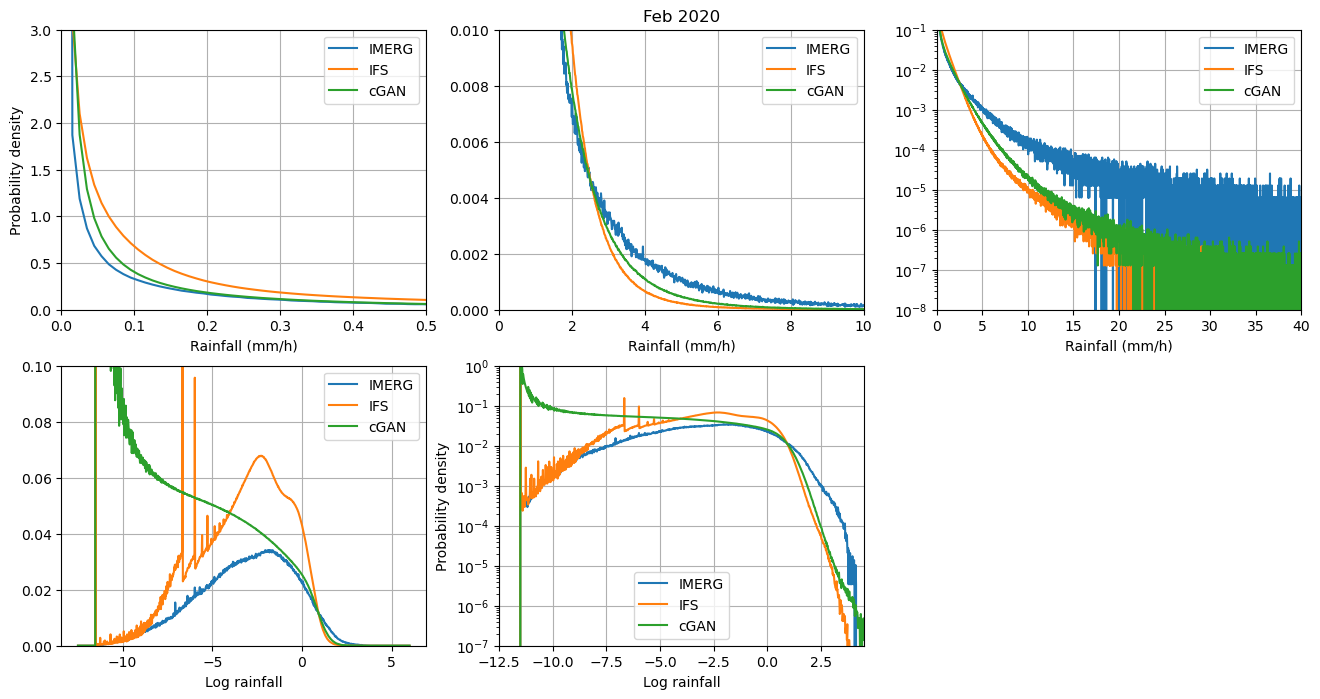

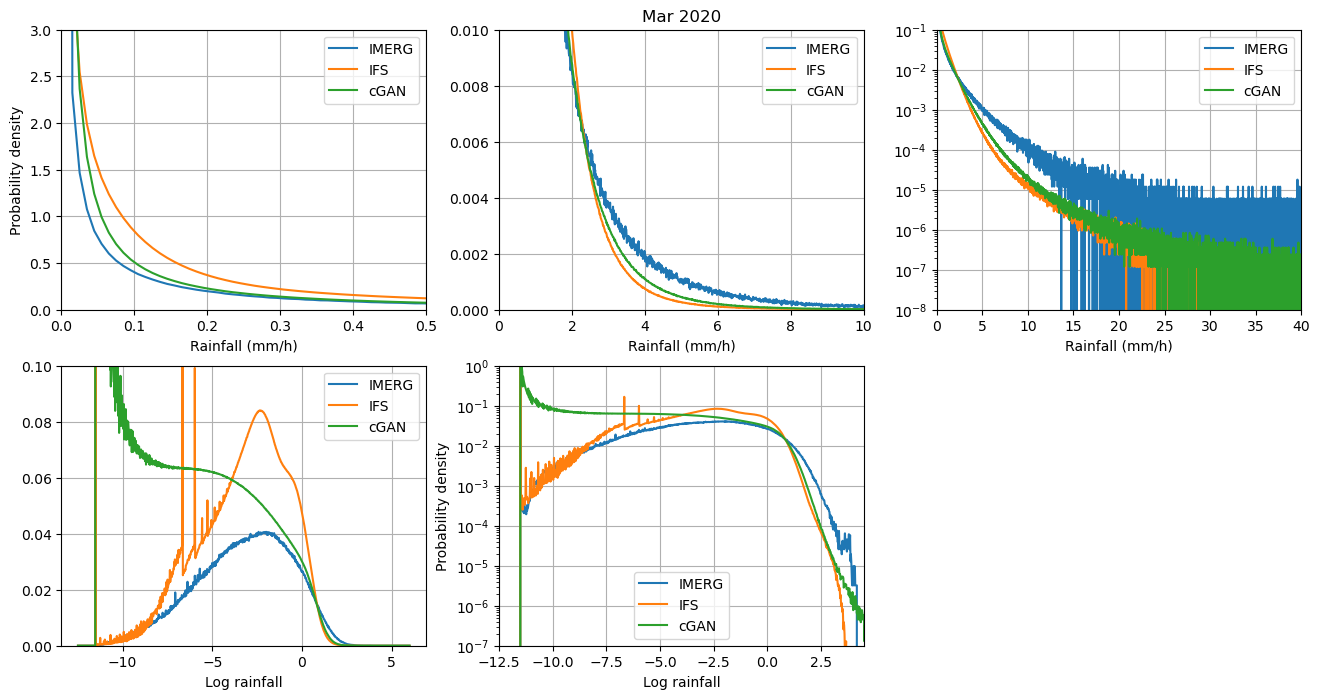

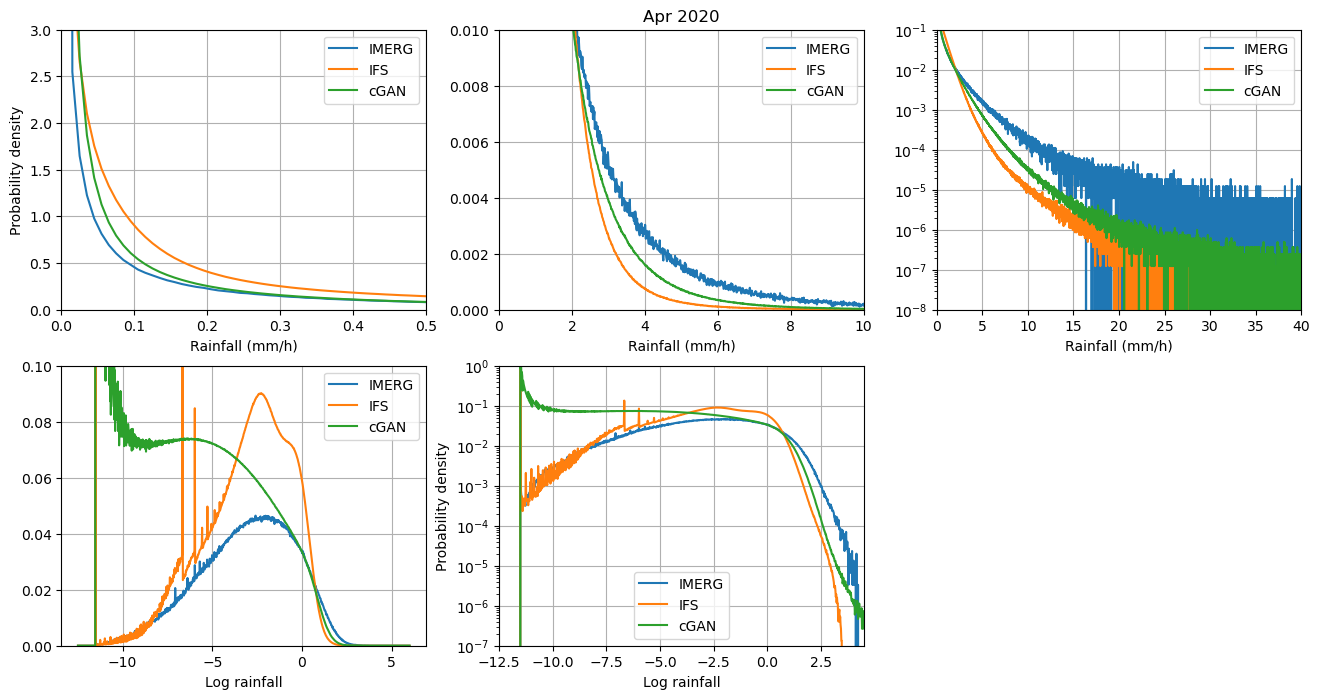

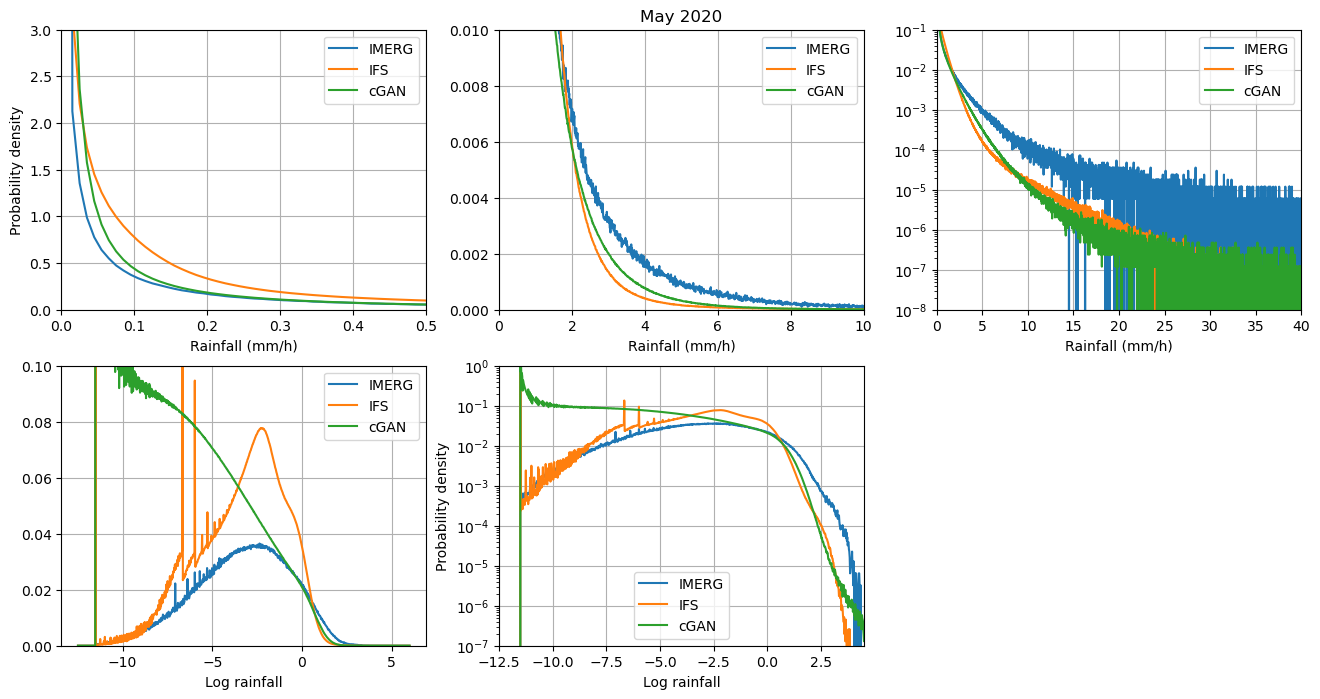

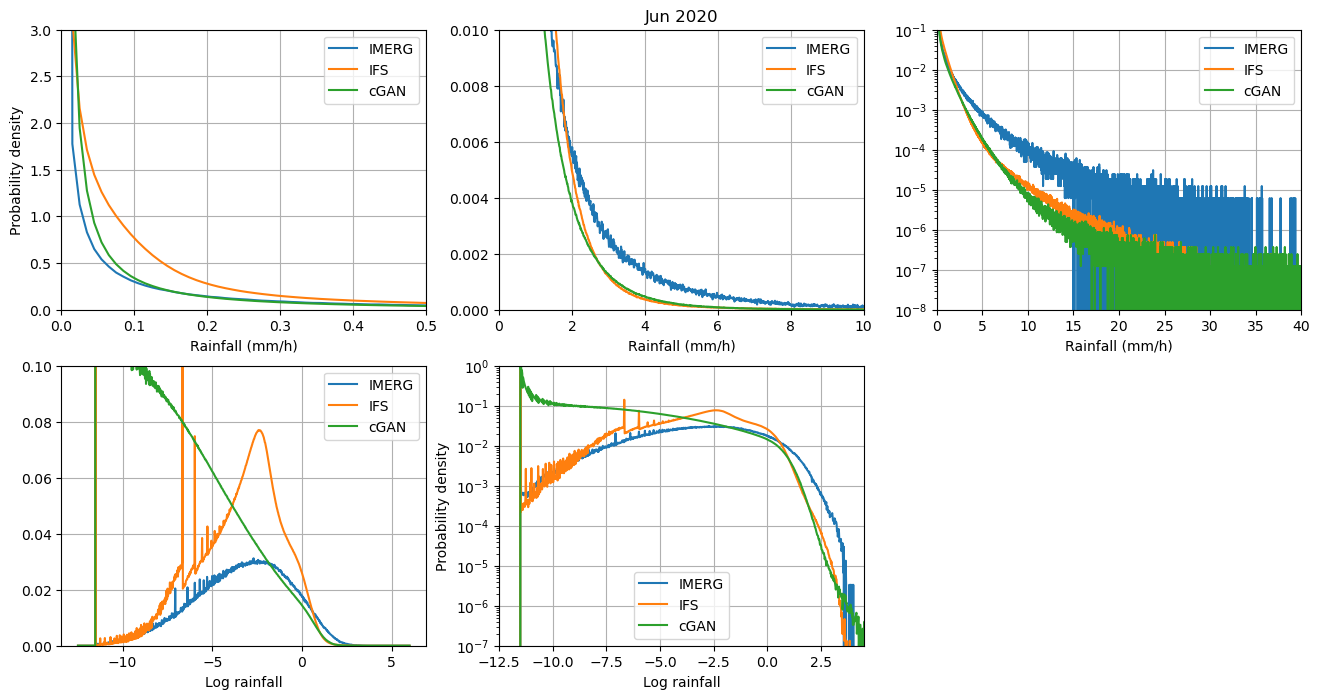

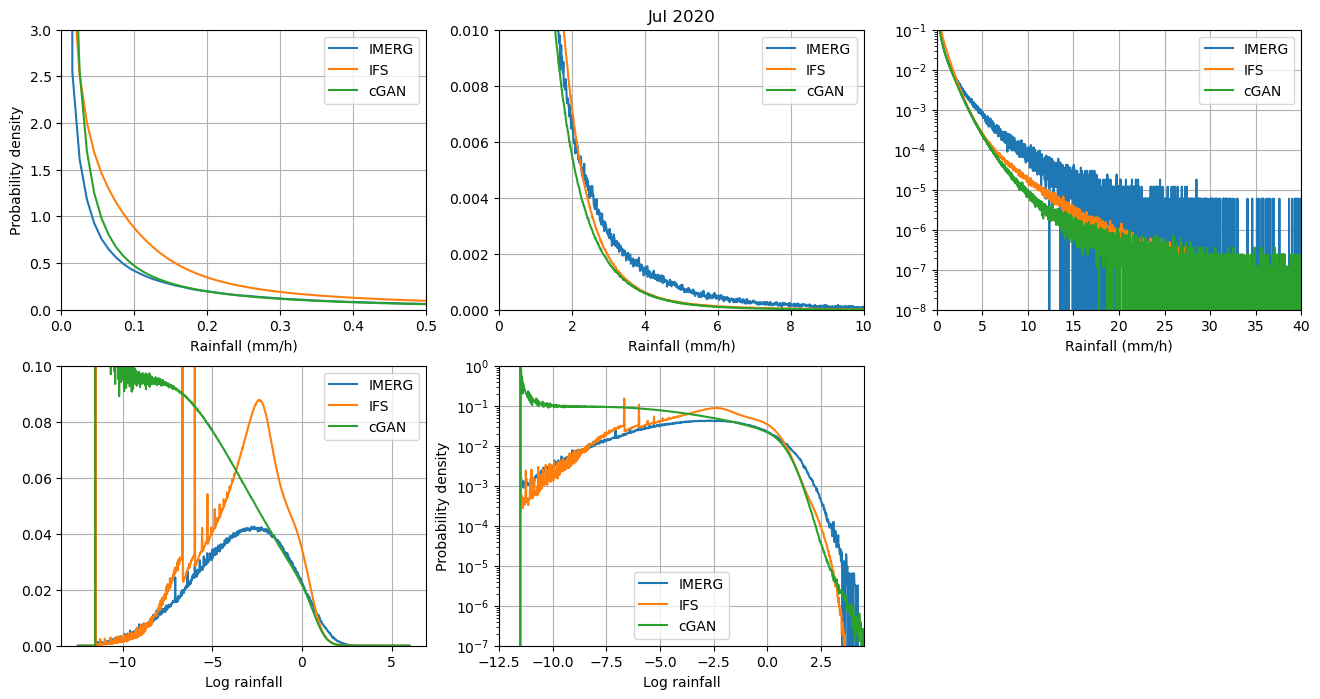

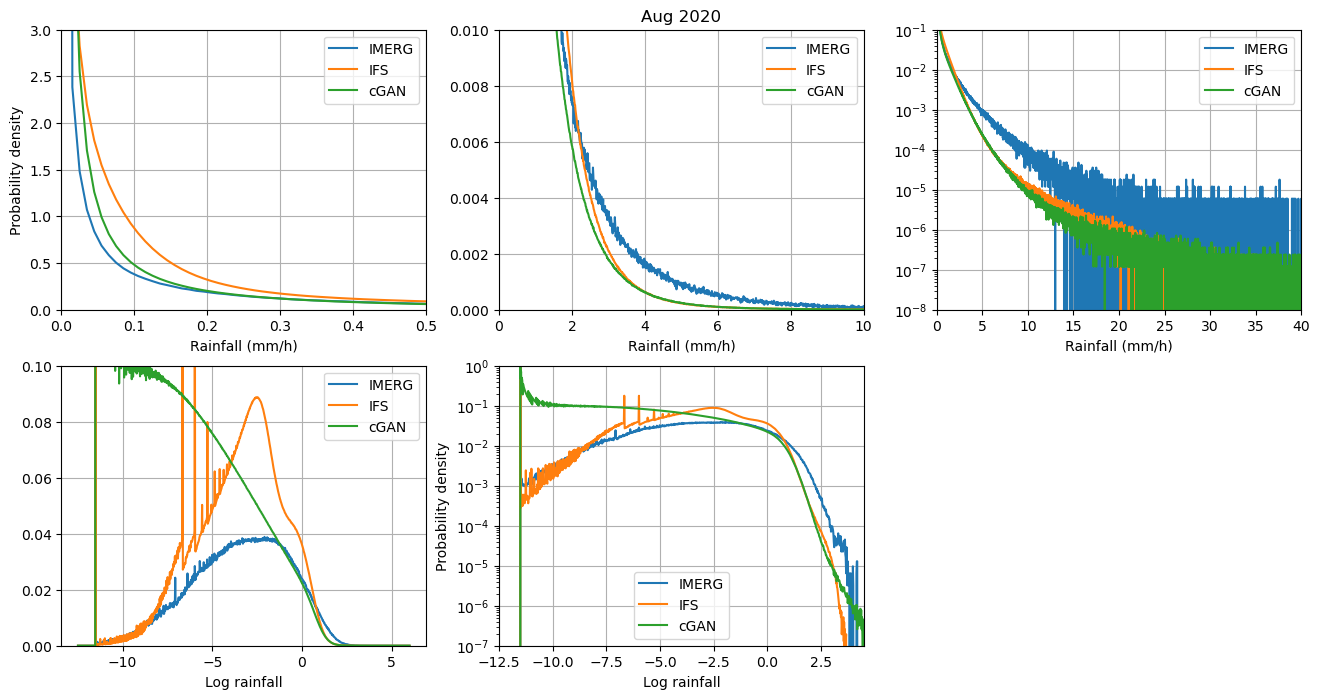

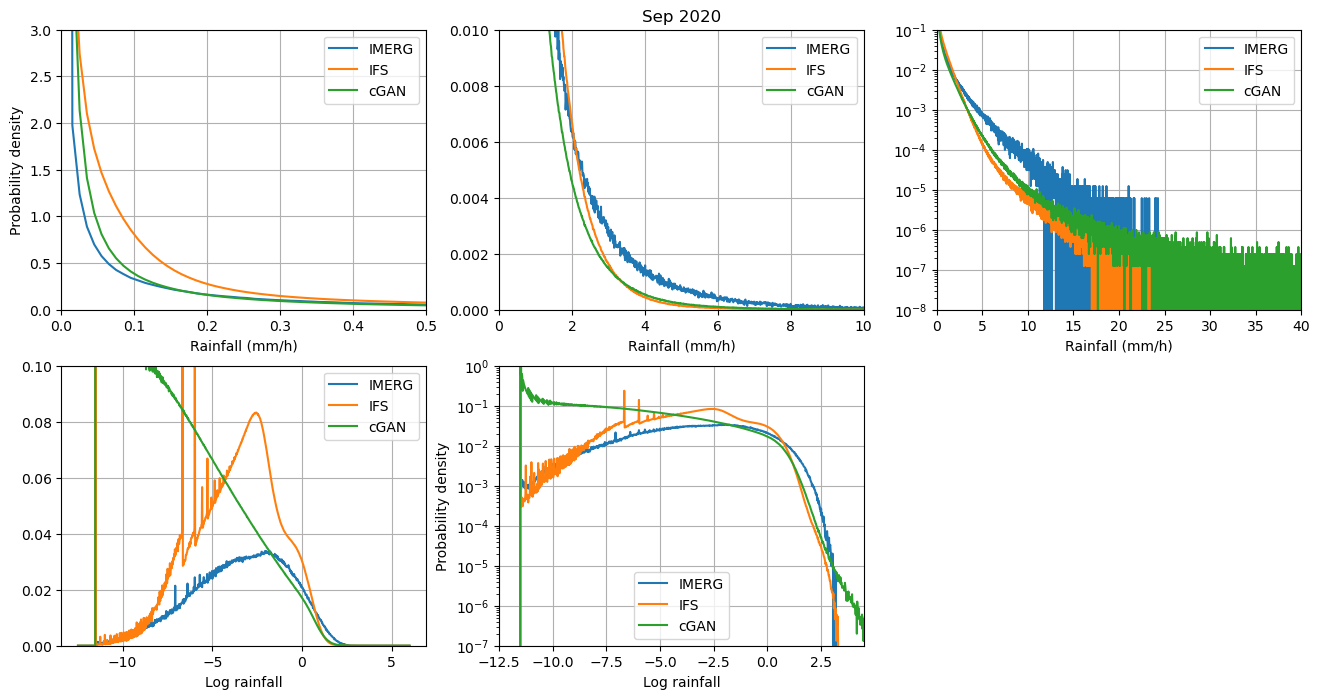

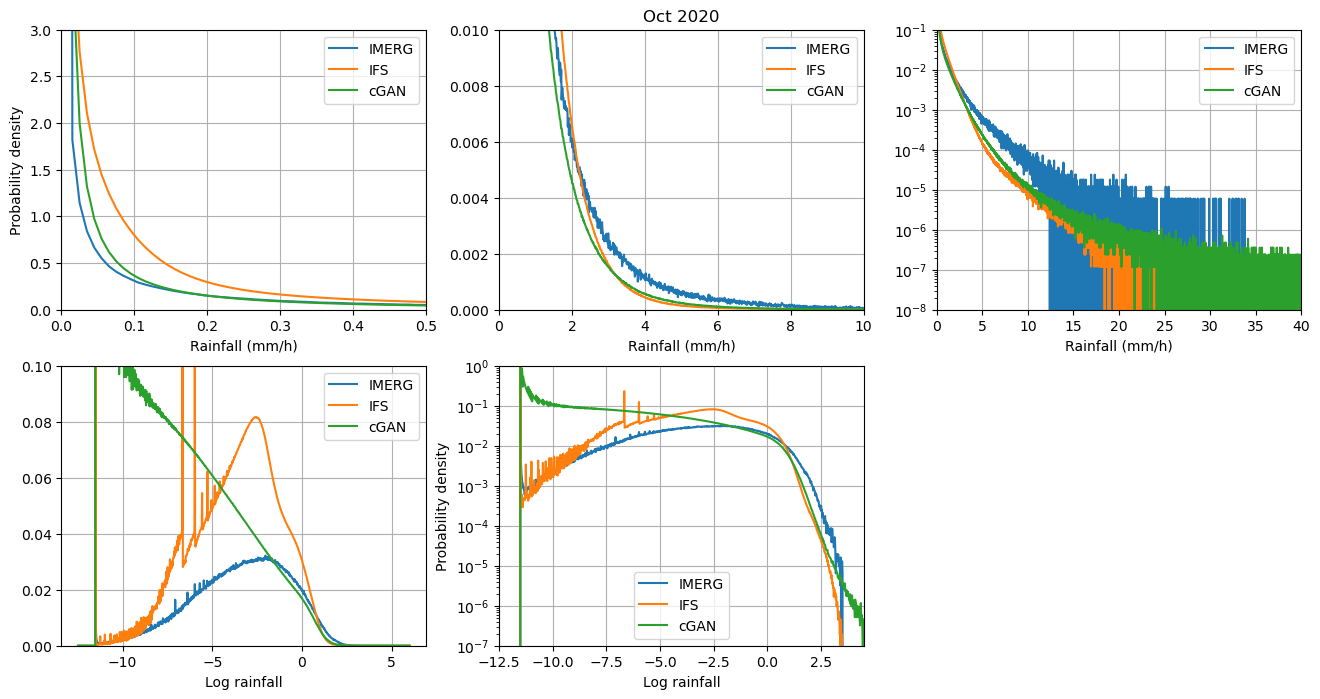

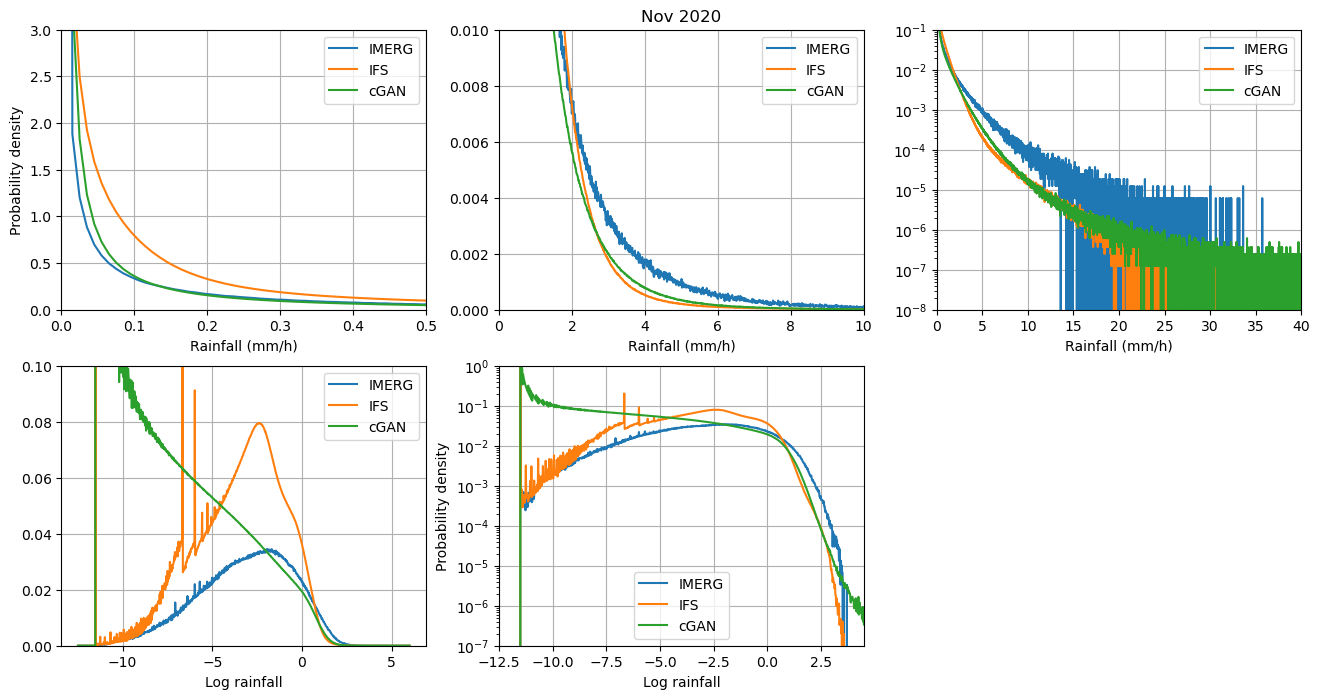

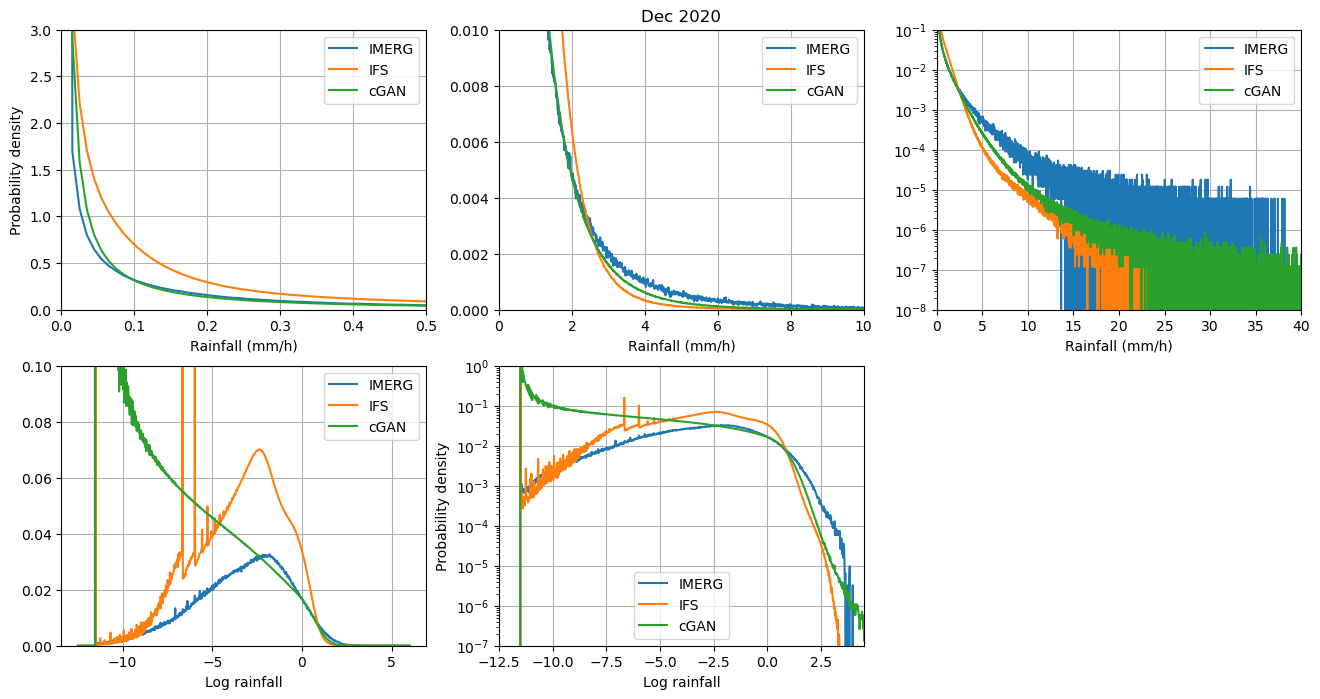

In [11]:
month_name = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
for month in range(1,13):
    start_day = (datetime(2020,month,1) - datetime(2020,1,1)).days
    if (month < 12):
        end_day = (datetime(2020,month+1,1) - datetime(2020,1,1)).days
    else:
        end_day = (datetime(2021,1,1) - datetime(2020,1,1)).days
    
    # Define the figure and each axis for the rows and columns
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,8))
    
    # axs is a 2 dimensional array. Flatten it into a 1-D array
    axs=axs.flatten()
    
    # Make the plots
    
    ax=axs[0]
    ax.plot(rainfall, np.mean(IMERG_PDF[start_day:end_day,:,:], axis=(0,1)), label="IMERG")
    ax.plot(rainfall, np.mean(IFS_PDF[start_day:end_day,:,:], axis=(0,1)) ,label="IFS")
    ax.plot(rainfall, np.mean(cGAN_PDF[start_day:end_day,:,:], axis=(0,1)), label="cGAN")
    ax.set_xlim(0,0.5)
    ax.set_ylim(0,3)
    ax.grid()
    ax.set_xlabel("Rainfall (mm/h)")
    ax.set_ylabel("Probability density")
    ax.legend()
    
    ax=axs[1]
    ax.plot(rainfall, np.mean(IMERG_PDF[start_day:end_day,:,:], axis=(0,1)), label="IMERG")
    ax.plot(rainfall, np.mean(IFS_PDF[start_day:end_day,:,:], axis=(0,1)) ,label="IFS")
    ax.plot(rainfall, np.mean(cGAN_PDF[start_day:end_day,:,:], axis=(0,1)), label="cGAN")
    ax.set_xlim(0,10)
    ax.set_ylim(0,0.01)
    ax.grid()
    ax.set_xlabel("Rainfall (mm/h)")
    ax.set_title(f"{month_name[month-1]} 2020")
    ax.legend()
    
    ax=axs[2]
    ax.semilogy(rainfall, np.mean(IMERG_PDF[start_day:end_day,:,:], axis=(0,1)), label="IMERG")
    ax.semilogy(rainfall, np.mean(IFS_PDF[start_day:end_day,:,:], axis=(0,1)) , label="IFS")
    ax.semilogy(rainfall, np.mean(cGAN_PDF[start_day:end_day,:,:], axis=(0,1)), label="cGAN")
    ax.set_xlim(0,40)
    ax.set_ylim(1e-8, 1e-1)
    ax.grid()
    ax.set_xlabel("Rainfall (mm/h)")
    ax.legend()
    
    ax=axs[3]
    ax.plot(rainfall_log, np.mean(IMERG_log_PDF[start_day:end_day,:,:], axis=(0,1)), label="IMERG")
    ax.plot(rainfall_log, np.mean(IFS_log_PDF[start_day:end_day,:,:], axis=(0,1)), label="IFS")
    ax.plot(rainfall_log, np.mean(cGAN_log_PDF[start_day:end_day,:,:], axis=(0,1)), label="cGAN")
    ax.set_ylim(0,0.1)
    ax.grid()
    ax.set_xlabel("Log rainfall")
    ax.legend()
    
    ax=axs[4]
    ax.semilogy(rainfall_log, np.mean(IMERG_log_PDF[start_day:end_day,:,:], axis=(0,1)), label="IMERG")
    ax.semilogy(rainfall_log, np.mean(IFS_log_PDF[start_day:end_day,:,:], axis=(0,1)), label="IFS")
    ax.semilogy(rainfall_log, np.mean(cGAN_log_PDF[start_day:end_day,:,:], axis=(0,1)), label="cGAN")
    ax.set_xlim(-12.5,4.5)
    ax.set_ylim(1e-7,1)
    ax.grid()
    ax.set_xlabel("Log rainfall")
    ax.set_ylabel("Probability density")
    ax.legend()
    
    ax=axs[5]
    ax.axis('off')

    # Save the picture
    if save_plots:
        plt.savefig(f"{plot_dir}/Rainfall_PDF_{month_name[month-1]}_2020.png", format="png", bbox_inches='tight')
    
    plt.show()